In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

C:\Users\kaiki\Documents\anaconda\envs\tensorflow_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load and clean data
df = pd.read_csv("D2.csv")
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)
df.dropna(subset=['posts', 'status'], inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [3]:
# Resample to balance classes 
max_count = df['status'].value_counts().max()
df_bal = pd.DataFrame()
for status, grp in df.groupby('status'):
    if len(grp) < max_count:
        grp_res = resample(grp, replace=True, n_samples=max_count, random_state=42)
    else:
        grp_res = grp
    df_bal = pd.concat([df_bal, grp_res])

df_bal.reset_index(drop=True, inplace=True)
print("After resampling:\n", df_bal['status'].value_counts())

df = df_bal


After resampling:
 status
negative         4374
neutral          4374
positive         4374
very negative    4374
Name: count, dtype: int64


In [4]:
# Build dynamic label map and one-hot labels
target_names = sorted(df['status'].unique())
num_classes = len(target_names)
label_map = {label: idx for idx, label in enumerate(target_names)}
df['label'] = df['status'].map(label_map)

In [5]:
# Tokenize with BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 128
enc = tokenizer(
    df['posts'].astype(str).tolist(), padding='max_length', truncation=True,
    max_length=MAX_LEN, return_tensors='np'
)
input_ids = enc['input_ids']
attention_mask = enc['attention_mask']


In [6]:
# Prepare labels and tf.data dataset
labels = tf.keras.utils.to_categorical(df['label'], num_classes=num_classes)
dataset = tf.data.Dataset.from_tensor_slices(
    ({'input_ids': input_ids, 'attention_mask': attention_mask}, labels)
)

In [7]:
# Train/val/test split
BATCH = 32
dataset = dataset.shuffle(buffer_size=len(df), seed=42)
n = len(df)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
train_ds = dataset.take(n_train).batch(BATCH)
val_ds = dataset.skip(n_train).take(n_val).batch(BATCH)
test_ds = dataset.skip(n_train + n_val).batch(BATCH)


In [8]:
# Build model
def build_model():
    bert = TFBertModel.from_pretrained('bert-base-uncased')
    in_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    in_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    x = bert(in_ids, attention_mask=in_mask).pooler_output
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    out = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=[in_ids, in_mask], outputs=out)

model = build_model()
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                       

In [9]:
# Compile model
optim = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-8)
metrics = ['accuracy']
for cls, idx in label_map.items():
    metrics += [
        tf.keras.metrics.Precision(name=f"prec_{cls}", class_id=idx),
        tf.keras.metrics.Recall(name=f"rec_{cls}", class_id=idx)
    ]

model.compile(
    optimizer=optim,
    loss='categorical_crossentropy',
    metrics=metrics
)


In [10]:
# Train
epochs = 10
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]
hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/10


438/438 [==============================] - ETA: 0s - loss: 0.7347 - accuracy: 0.7062 - prec_negative: 0.6746 - rec_negative: 0.4947 - prec_neutral: 0.7841 - rec_neutral: 0.6212 - prec_positive: 0.8135 - rec_positive: 0.6559 - prec_very negative: 0.8311 - rec_very negative: 0.7415

C:\Users\kaiki\Documents\anaconda\envs\tensorflow_env\lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


438/438 [==============================] - 2936s 7s/step - loss: 0.7347 - accuracy: 0.7062 - prec_negative: 0.6746 - rec_negative: 0.4947 - prec_neutral: 0.7841 - rec_neutral: 0.6212 - prec_positive: 0.8135 - rec_positive: 0.6559 - prec_very negative: 0.8311 - rec_very negative: 0.7415 - val_loss: 0.3940 - val_accuracy: 0.8376 - val_prec_negative: 0.6283 - val_rec_negative: 0.9684 - val_prec_neutral: 0.9709 - val_rec_neutral: 0.6096 - val_prec_positive: 0.9718 - val_rec_positive: 0.9039 - val_prec_very negative: 0.9762 - val_rec_very negative: 0.8367
Epoch 2/10
438/438 [==============================] - 3003s 7s/step - loss: 0.3165 - accuracy: 0.8921 - prec_negative: 0.8230 - rec_negative: 0.8168 - prec_neutral: 0.8851 - rec_neutral: 0.8217 - prec_positive: 0.9451 - rec_positive: 0.9451 - prec_very negative: 0.9459 - rec_very negative: 0.9416 - val_loss: 0.1298 - val_accuracy: 0.9668 - val_prec_negative: 0.9627 - val_rec_negative: 0.9260 - val_prec_neutral: 0.9515 - val_rec_neutral: 0.

In [11]:
# Evaluate predictions
y_true, y_score = [], []
for x_batch, y_batch in test_ds:
    probs = model.predict(x_batch)
    y_score.append(probs)
    y_true.extend(np.argmax(y_batch.numpy(), axis=1))
y_score = np.vstack(y_score)

y_pred = np.argmax(y_score, axis=1)

1/1 [==============================] - 4s 4s/step


In [12]:
# Classification report
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

               precision    recall  f1-score   support

     negative     0.9861    0.9907    0.9884       429
      neutral     0.9927    0.9761    0.9843       418
     positive     0.9851    0.9957    0.9904       465
very negative     0.9977    0.9977    0.9977       439

     accuracy                         0.9903      1751
    macro avg     0.9904    0.9900    0.9902      1751
 weighted avg     0.9903    0.9903    0.9903      1751



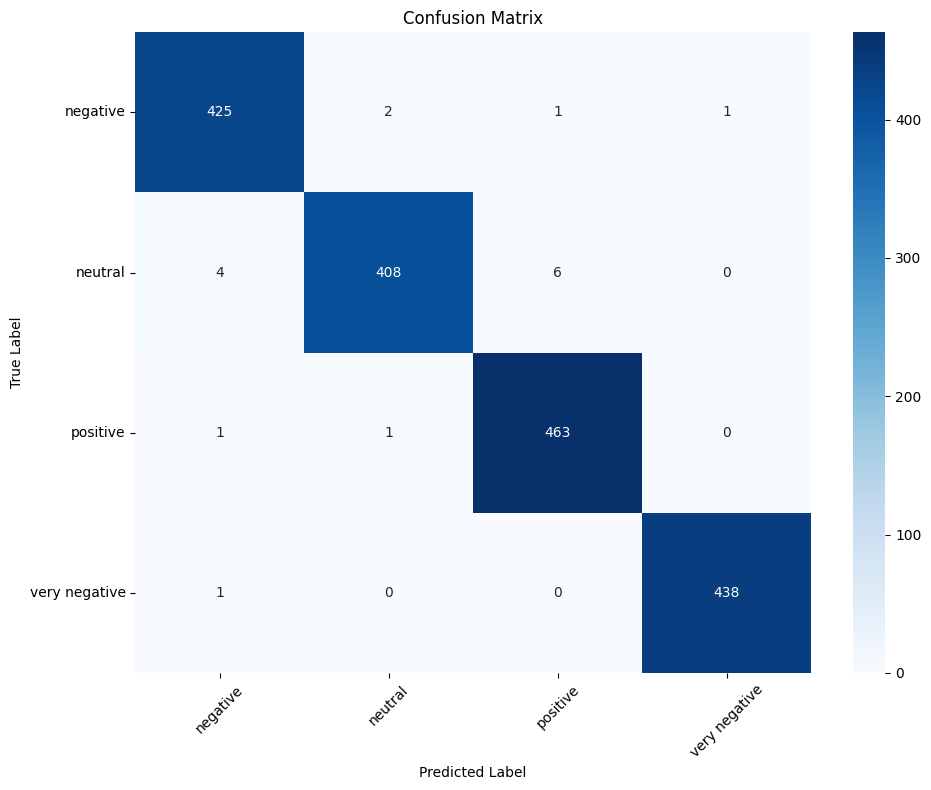

In [17]:
# Confusion matrix
import seaborn as sns
plt.figure(figsize=(10, 8))  
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



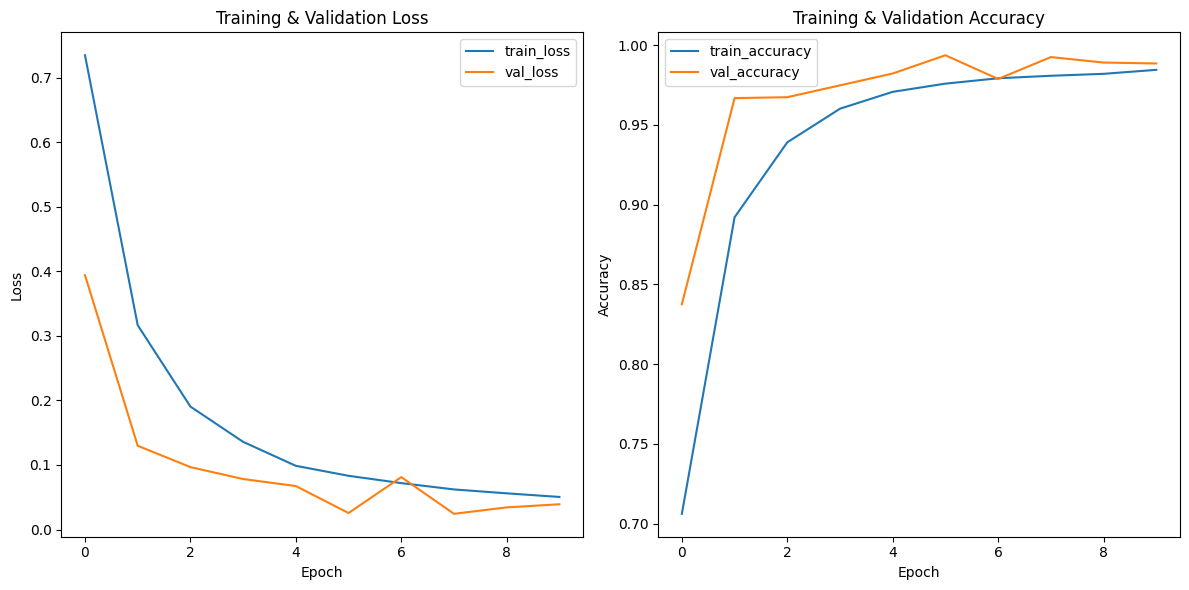

In [14]:
# Plot training & validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='train_accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


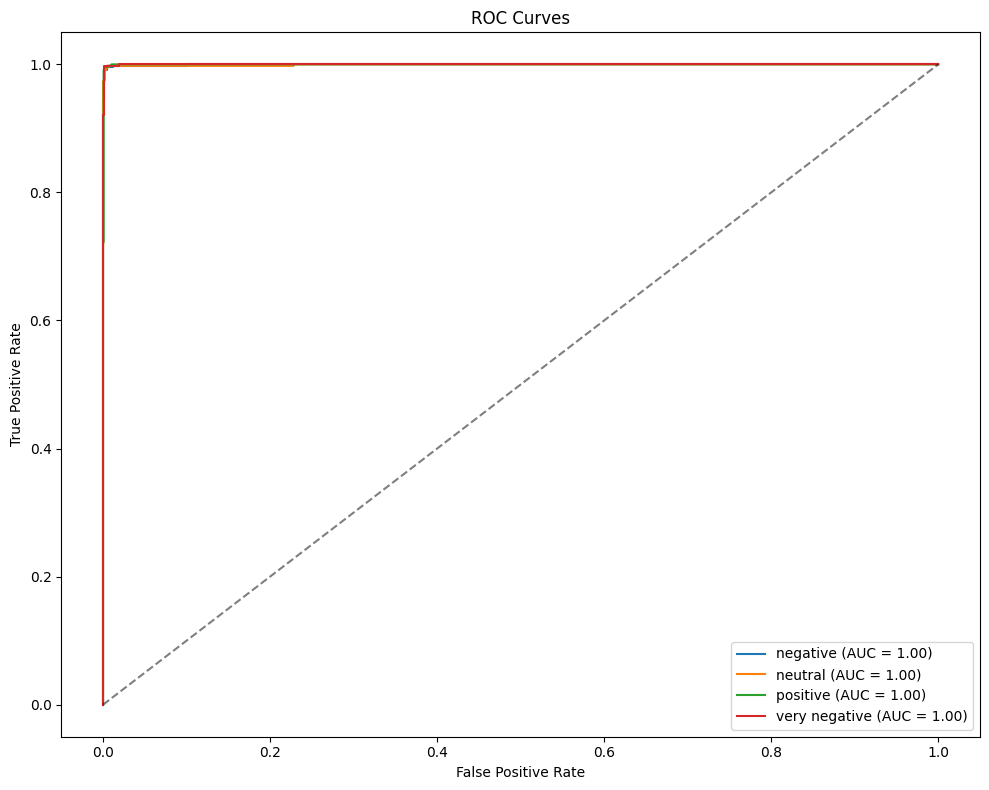

In [15]:
# ROC Curves 
# One-hot encode true labels for ROC/PR
from tensorflow.keras.utils import to_categorical
y_true_bin = to_categorical(y_true, num_classes=num_classes)

plt.figure(figsize=(10, 8))
for i, cls in enumerate(target_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


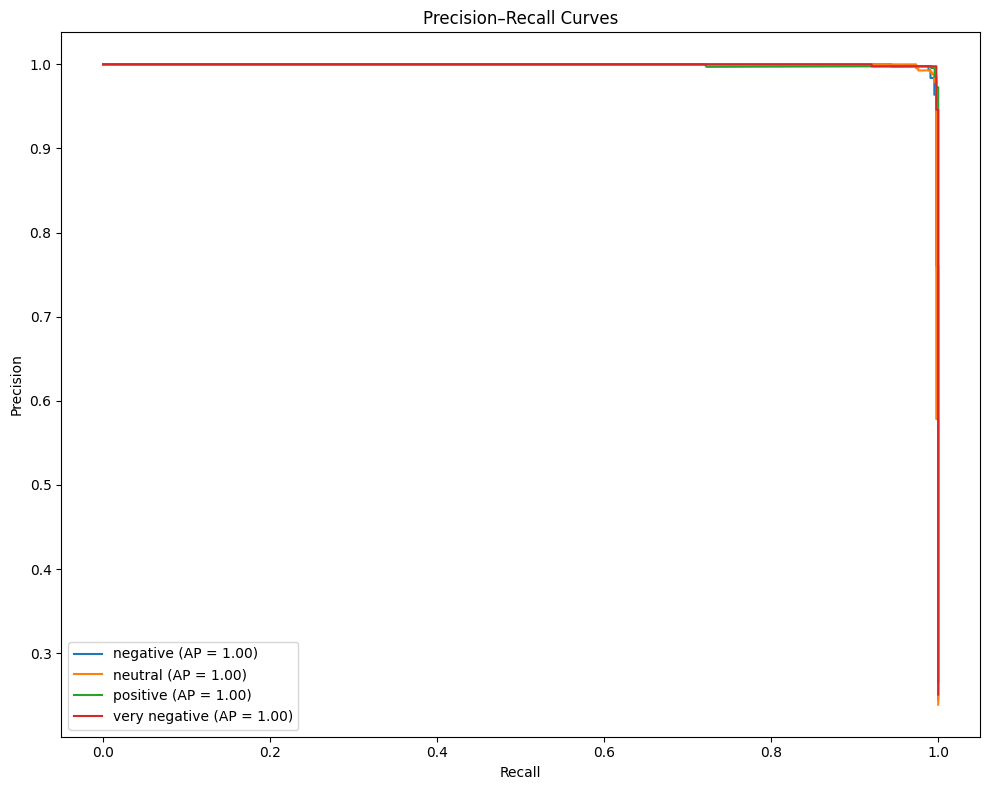

In [16]:
# Precision–Recall Curves
plt.figure(figsize=(10, 8))
for i, cls in enumerate(target_names):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f"{cls} (AP = {ap:.2f})")
plt.title('Precision–Recall Curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()


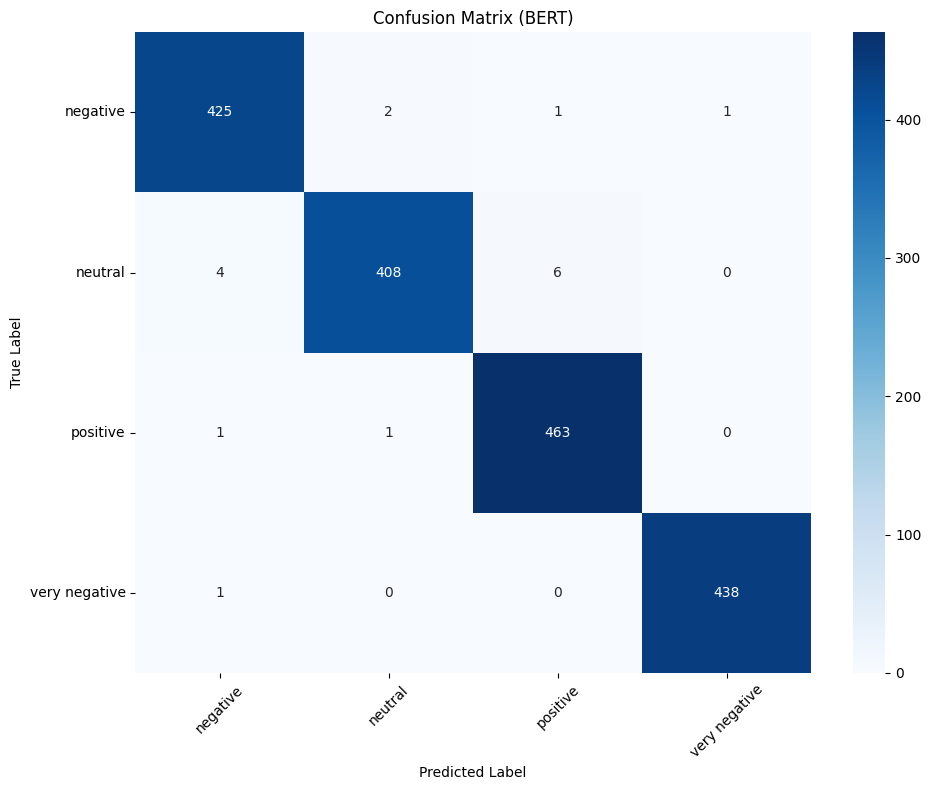

In [19]:
# Confusion matrix 
import seaborn as sns
plt.figure(figsize=(10, 8))  
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)

plt.title('Confusion Matrix (BERT)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


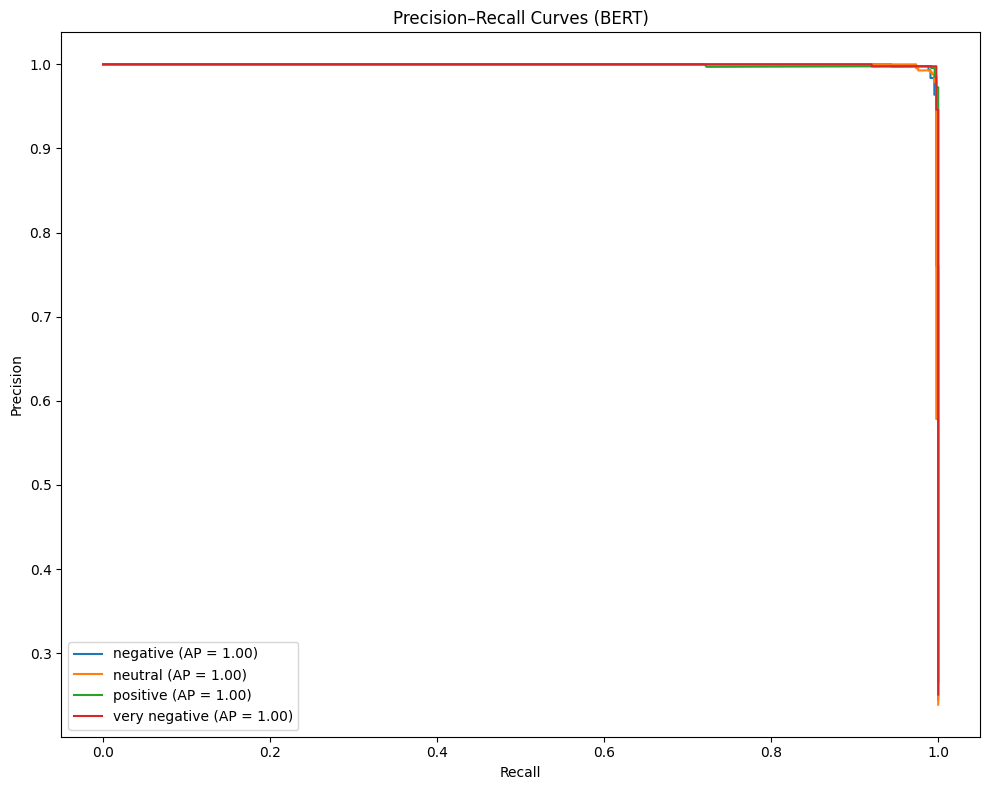

In [20]:
# Precision–Recall Curves
plt.figure(figsize=(10, 8))
for i, cls in enumerate(target_names):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f"{cls} (AP = {ap:.2f})")
plt.title('Precision–Recall Curves (BERT)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

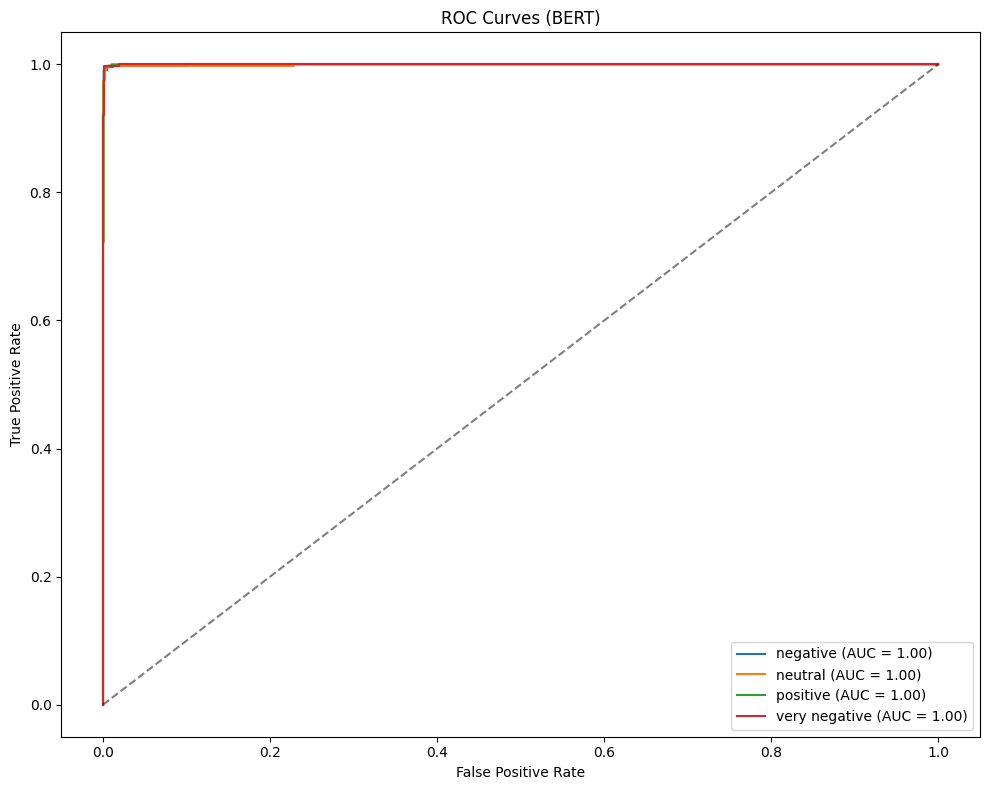

In [21]:
# ROC Curves 
# One-hot encode true labels for ROC/PR
from tensorflow.keras.utils import to_categorical
y_true_bin = to_categorical(y_true, num_classes=num_classes)

plt.figure(figsize=(10, 8))
for i, cls in enumerate(target_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.title('ROC Curves (BERT)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

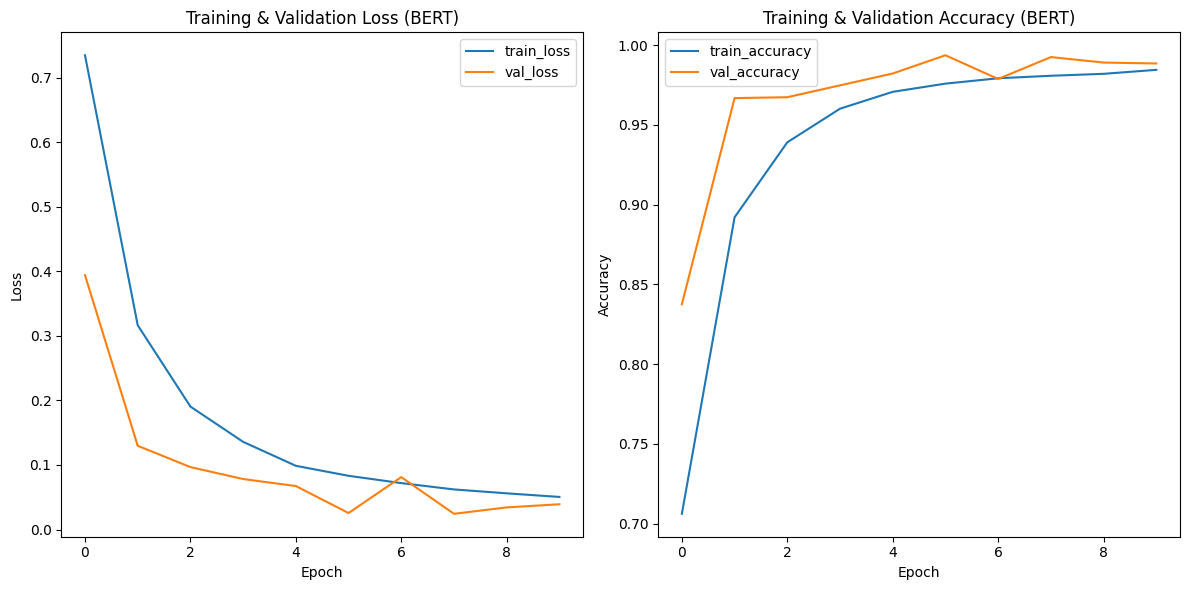

In [22]:
# Plot training & validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title('Training & Validation Loss (BERT)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='train_accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.title('Training & Validation Accuracy (BERT)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()
